`Описание проекта:` нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.

Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Импортируем библиотеки

In [1]:
!pip install scikit-learn==1.1.2

     |████████████████████████████████| 30.8 MB 2.5 MB/s eta 0:00:01█████████             | 18.3 MB 2.5 MB/s eta 0:00:05
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import loguniform
from sqlalchemy import create_engine 
import seaborn as sns
pd.set_option('display.max_columns', 500)

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import sqlalchemy
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import  f1_score, confusion_matrix, make_scorer
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from multiprocessing import Pool

## Подключитесь к базе. Загрузите таблицы sql


Подключаемся к базе данных

In [3]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db'
} 


connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)


con = create_engine(connection_string) 

## Проведите первичное исследование таблиц

Создадим функции для поиска пропущенных значений и дубликатов

In [4]:
def miss(data):
    return data.isna().sum()

def dup(data):
    return data.duplicated().sum()

In [5]:

query = '''
SELECT *
FROM collisions
where collision_date > '2012-01-01' and COLLISION_DAMAGE != 'scratch'
'''
df_collisions = pd.read_sql_query(query, con) 

In [6]:
miss(df_collisions), dup(df_collisions)

(case_id                            0
 county_city_location               0
 county_location                    0
 distance                           0
 direction                      23989
 intersection                     714
 weather_1                        412
 location_type                  69147
 collision_damage                   0
 party_count                        0
 primary_collision_factor         519
 pcf_violation_category          2335
 type_of_collision               1045
 motor_vehicle_involved_with      591
 road_surface                     802
 road_condition_1                 716
 lighting                         494
 control_device                   621
 collision_date                     0
 collision_time                  1306
 dtype: int64,
 0)

In [7]:
query = '''
SELECT *
FROM parties
where party_type = 'car'
'''

parties = pd.read_sql_query(query, con) 


In [8]:
miss(parties), dup(parties)

(id                           0
 case_id                      0
 party_number                 0
 party_type                   0
 at_fault                     0
 insurance_premium       219689
 party_sobriety           44207
 party_drug_physical    2191243
 cellphone_in_use        374750
 dtype: int64,
 0)

In [9]:
query = '''
SELECT *
FROM vehicles
'''
vehicles = pd.read_sql_query(query, con) 


In [10]:
miss(vehicles), dup(vehicles)

(id                          0
 case_id                     0
 party_number                0
 vehicle_type                0
 vehicle_transmission    23659
 vehicle_age             24582
 dtype: int64,
 0)

##  Проведите статистический анализ факторов ДТП

Проверим когда происходит наибольшее кол-во аварий по таблице collisions

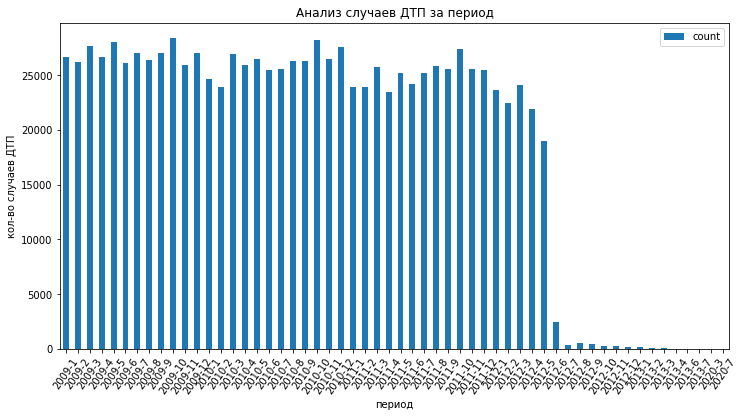

In [11]:
query = '''SELECT extract(year from collision_date) AS year,
           extract(month from collision_date) AS month,
           count(case_id)
FROM collisions where COLLISION_DAMAGE != 'scratch'
group by extract(year from collision_date) , extract(month from collision_date)'''
df_collisions = pd.read_sql_query(query, con)

df_collisions['year'] = df_collisions['year'].astype(int).astype(str)
df_collisions['month'] = df_collisions['month'].astype(int).astype(str)

df_collisions['all'] = df_collisions['year'] + '-' + df_collisions['month']
df_collisions

df_collisions[['all', 'count']].plot(x = 'all',y = 'count', figsize = (12,6), kind = 'bar')
plt.xticks(rotation=55) 
plt.xlabel('период')
plt.ylabel('кол-во случаев ДТП')
plt.title('Анализ случаев ДТП за период')
plt.show()

`Вывод:` анализ ДТП не выявляет ярко выраженной тенденции, однако, можно заметить что общее количество ДТП имеет небольшую тенденцию к снижению в начале года (Январь). возможно, это связано с новогодними праздниками и тем что авто используется менее интенсивно чем в другие месяцы.

Рост ДТП наблюдается в сентябре, скорее всего это связано с ухудшением погоды и началом осенних дождей.



Чтобы выяснить реальные причины, разобъём задачу на состовляющие, разделим задачу на подзадачи и передадим коллегам.

Примеры задач для коллег:


- Изучить зависимость ДТП от состояния дорожного полотна
- Изучить зависимость ДТП от состояния освящённости дороги
- Изучить зависимость ДТП при нахождении на перекрёстке дорог
- Изучить есть зависимость ДТП от уровня опасности участка дорого
- Изучить зависимость ДТП от погодных условий
- Изучить зависимость ДТП от использования громкой связи за рулём
- Изучить зависимость ДТП от времени суток

Выберем для анализа две задачи и проанализируем их:

- Зависимость ДТП от погодных условий
- Зависимость ДТП от состояния освящённости дороги

#### Задача 1: - Зависимость ДТП от погодных условий

- выполнить запрос к базе данных SQL
- построить графическое отображение
- сделать вывод о проделанной работе

Запрос к базе данных

In [12]:
query = '''
SELECT collisions.weather_1 , parties.at_fault
FROM collisions
LEFT JOIN parties on parties.case_id = collisions.case_id
'''
order_1 = pd.read_sql_query(query, con) 

График

<AxesSubplot:>

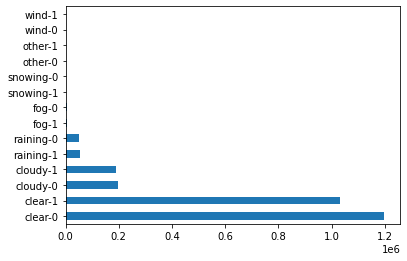

In [13]:
order_1['at_fault'] = order_1['at_fault'].astype(str)
order_1['all'] = order_1['weather_1'] + '-' + order_1['at_fault']
order_1['all'].value_counts().plot(kind = 'barh')

`Вывод:` из графика выше следует что за исключением параметра 'ясная погода' сколько нибудь значительной разницы между присутствие или отсутствием погодного явления не надлюдается.

ДТП проиходят одинаково часто в дождь или при его отсутствии.

Папаметр clear - ясня погода показывает незначительную связь, на грани погрешности.

#### Задача 2: Зависимость кол-во ДТП от состояния освящённости дороги

- выполнить запрос к базе данных SQL
- построить графическое отображение
- сделать вывод о проделанной работе

Запрос к базе данных

In [14]:
query = '''
SELECT collisions.LIGHTING , parties.at_fault
FROM collisions
LEFT JOIN parties on parties.case_id = collisions.case_id
'''
order_2 = pd.read_sql_query(query, con) 

График

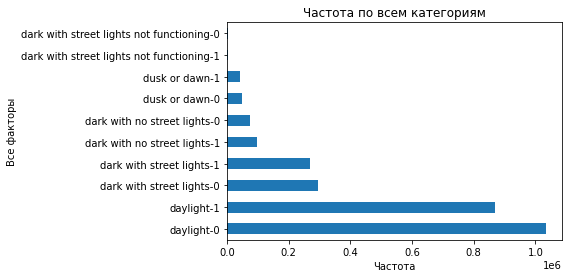

In [15]:
order_2['at_fault'] = order_2['at_fault'].astype(str)
order_2['all'] = order_2['lighting'] + '-' + order_2['at_fault']
order_2['all'].value_counts().plot(kind = 'barh')
ax = order_2['all'].value_counts().plot(kind='barh')

# название таблицы
ax.set_title("Частота по всем категориям")

# ось Х
ax.set_xlabel("Частота")

# ось у
ax.set_ylabel("Все факторы")

plt.show()

`Вывод:` не прослеживается корреляции отсещённости и ДТП, за исключением наличия / отсутствия дневного света, но эти показатели очень близки и поэтому, ненадёжны. Буди считать что явной взаимосвязи нет.

## Создайте модель для оценки водительского риска

Запрос к базе данных

In [16]:

query = '''
SELECT *
FROM collisions as c
left join parties as p on p.case_id = c.case_id
left join vehicles as v on v.case_id = c.case_id
where extract(year from collision_date) = 2012 and COLLISION_DAMAGE != 'scratch' and party_type = 'car'
'''
union_df = pd.read_sql_query(query, con) 

Соединяем все три таблицы чтобы работать с одной таблицей

Изучаем и выбираем факторы которые могуть повлиять на вероятность ДТП

In [17]:
columns= ['case_id',  # после объединения колонка не нужна -- удаляем
        'county_city_location', # числовое описание района -- оставляем
        'county_location',  # дублирует `county_city_location` -- удаляем
        'distance', # протяженность пути -- оставляем
       'direction', # неточная формулировка (стороны света) -- убираем
       'intersection', # наличие перекрёстка в месте ДТП -- оставляем
       'weather_1', # погодняе условия -- оставляем
       'location_type',# тип дороги -- оставляем
       'collision_damage', # повреждения не интересуют, важен факт ДТП -- удаляем
       'party_count', # Обьект столковения нас не интересует -- удаляем
       'primary_collision_factor',# какие правила ДТП нарушены -- оставляем
       'pcf_violation_category',# наличие алкоголья -- оставляем
       'type_of_collision',# тип ДТП не имеет значения -- удаляем
       'motor_vehicle_involved_with',# побочные участники дтп вносят шум -- удаляем
       'road_surface', # дорожное покрытие -- оставляем
       'road_condition_1', # Состояние дорожного полотна - важно, оставляем
       'lighting',  # освещение дорожного полотна -- оставляем
       'control_device', # нет описания -- оставим на всякий случай
        'collision_date'# дата ДТП -- оставляем
        'collision_time',# время ДТП -- оставляем
         'id',# не несёт полезной инфы -- удаляем 
       'case_id',# не несёт полезной инфы -- удаляем 
        'party_number',#все порядковые колонки с удаляем
        'party_type',# удаляем так как мы уже выбрали ранее все автомобили
         'at_fault',# целевой параметр -- оставляем
       'insurance_premium',# нет описания опасности поетому -- удаляем 
        'party_sobriety', # нет данных -- удаляем       
        'party_drug_physical',# состояние участника на тесте нам не известно -- удаляем    
       'cellphone_in_use',# использование телефона во время вождения понижает внимательность -- оставляем
        'id',# не несёт полезной инфы -- удаляем 
       'case_id',# не несёт полезной инфы -- удаляем 
        'party_number',# не несёт полезной инфы -- удаляем 
        'vehicle_type',#тип кузова -- может повлиять на ДТП, тк от типа кузова может зависеть поведение авто и его управляемость -- оставим
       'vehicle_transmission',#  трансмиссия -- оставим, возможно механника как более сложный в управлении тип влияет на ДТП
         'vehicle_age']# возраст авто -- оставляем

На основании анализа выше - удалим ненужные признаки и сохраним в переменную union_df

In [18]:
union_df = union_df[['county_city_location','pcf_violation_category','primary_collision_factor','party_sobriety','distance','intersection','weather_1','road_surface','at_fault','road_condition_1','lighting','control_device','collision_date','collision_time','cellphone_in_use','vehicle_age', 'vehicle_type', 'vehicle_transmission']]

In [19]:
union_df.head()

,county_city_location,pcf_violation_category,primary_collision_factor,party_sobriety,distance,intersection,weather_1,road_surface,at_fault,road_condition_1,lighting,control_device,collision_date,collision_time,cellphone_in_use,vehicle_age,vehicle_type,vehicle_transmission
0,3000,unsafe lane change,vehicle code violation,had not been drinking,900.0,0.0,clear,dry,0,normal,daylight,none,2012-01-26,08:50:00,0.0,NaN,None,None
1,0900,unknown,unknown,had not been drinking,200.0,0.0,clear,dry,0,normal,daylight,functioning,2012-01-15,16:15:00,0.0,4.0,sedan,manual
2,3026,unsafe lane change,vehicle code violation,had not been drinking,1.0,0.0,clear,dry,0,normal,daylight,none,2012-01-03,09:16:00,0.0,NaN,None,None
3,3801,speeding,vehicle code violation,impairment unknown,22.0,0.0,other,None,1,normal,dark with street lights,none,2012-01-22,05:55:00,NaN,NaN,None,None
4,1941,improper turning,vehicle code violation,had not been drinking,0.0,1.0,clear,dry,1,normal,daylight,functioning,2012-01-18,07:22:00,0.0,2.0,hatchback,auto


Заполним пропуски

In [20]:
union_df.loc[union_df['vehicle_age'].isna(),'vehicle_age'] = 0
union_df.loc[union_df['vehicle_transmission'].isna(), 'vehicle_transmission' ] = 'none'
union_df.loc[union_df['vehicle_type'].isna(), 'vehicle_type' ] = 'none'
union_df.loc[union_df['cellphone_in_use'].isna(),'cellphone_in_use'] = 0
union_df.loc[union_df['intersection'].isna(),'intersection'] = 0
union_df.loc[union_df['control_device'].isna(),'control_device'] = 'none'
union_df.loc[union_df['lighting'].isna(),'lighting'] = 'none'
union_df.loc[union_df['weather_1'].isna(),'weather_1'] = 'other'
union_df = union_df.dropna(subset=['road_surface','road_condition_1','pcf_violation_category','primary_collision_factor','party_sobriety']) # удаляем пропуски

Проверим на выбросы расстояние от главной дороги 'distance'

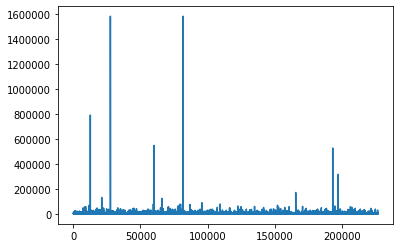

In [21]:
union_df['distance'].plot()
plt.ticklabel_format(style='plain', axis='y')

Проверим на выбросы расстояние от главной дороги 'vehicle_age'

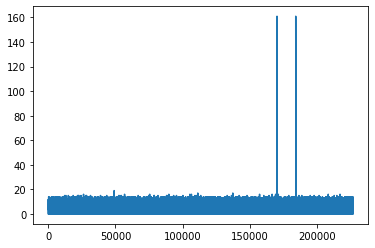

In [22]:
union_df['vehicle_age'].plot()
plt.ticklabel_format(style='plain', axis='y')

In [23]:
union_df['vehicle_age'].value_counts()

0.0      112726
3.0       20882
4.0       14119
2.0       12390
5.0       11305
6.0        8201
7.0        8030
8.0        7360
9.0        5873
1.0        5480
10.0       4132
11.0       2885
12.0       1807
13.0       1137
14.0        583
15.0         79
16.0         20
17.0          4
161.0         4
19.0          1
Name: vehicle_age, dtype: int64

Удалим выбирающиеся значения большие 200 000 метров от главной дороги

In [24]:
union_df = union_df.loc[union_df['distance'] < 200000]

Удалим выбирающиеся значения возраста авто большие 19 лет.

In [25]:
union_df = union_df.loc[union_df['vehicle_age'] <= 19]

Готовим данные перед разделением выборок

In [26]:
categorical = union_df.select_dtypes(exclude=np.number).columns.to_list()
numeric = union_df.select_dtypes(include=np.number).columns.to_list()
numeric = ['distance', 'intersection', 'cellphone_in_use', 'vehicle_age']

In [27]:
X = union_df.drop(['at_fault'], axis=1)
y = union_df['at_fault']

Делим выборки

In [28]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [29]:
# Разделение на выборки
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.5, stratify=y_train, random_state=42)

Создаём пайплайны

In [30]:
# масштабирование числовых данных
numeric_preproces = Pipeline([('scaler',StandardScaler())])

# кодирование категориальных данных 
categorial_preproces = Pipeline([('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

# процесс подготовки данных для Случайного леса
preprocessor_for_tree = ColumnTransformer([
    (
        'categorical', 
        categorial_preproces, 
        categorical
    ),
    (
        'numerical', 
        numeric_preproces, 
        numeric
    )
])

# подготовка данных для бустинга
preprocessor_for_boost = ColumnTransformer([
    (
        'numerical', 
        numeric_preproces, 
        numeric
    )
])

pipe_for_tree = Pipeline([
    ('preprocessor', preprocessor_for_tree),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipe_for_catboost = Pipeline([
    ('preprocessor', preprocessor_for_boost),
    ('classifier', CatBoostClassifier(random_state=42))
])


pipe_for_lgbm = Pipeline([
    ('preprocessor', preprocessor_for_boost),
    ('classifier', LGBMClassifier(random_state=42))
])

Проверка на дисбаланс классов (0 и 1)

In [31]:
# Провидим анализ дисбаланса классов, считаем кол-во 0 и 1 и их соотношение
target_counts = union_df['at_fault'].value_counts()
target_ratio = target_counts / len(union_df)

print("Распределение классов:")
print(target_counts)
print("\nСоотношение классов:")
print(target_ratio)


Распределение классов:
1    109578
0    107428
Name: at_fault, dtype: int64

Соотношение классов:
1    0.504954
0    0.495046
Name: at_fault, dtype: float64


`Вывод:` дисбаланса класов нет

`Выбор метрики:` обоснование выбора метрики F1 для системы оценки риска ДТП по выбранному маршруту движения можно представить следующим образом:

Учет баланса между полнотой и точностью: Метрика F1 учитывает как полноту (recall), так и точность (precision) модели. В случае оценки риска ДТП, важно достичь баланса между выявлением действительно рисковых маршрутов (высокая полнота) и минимизацией ложно-положительных предупреждений (высокая точность).

Подчеркивание важности правильного выявления рисковых маршрутов: В контексте безопасности дорожного движения, цель системы - предупреждать водителей о потенциальных опасностях на выбранных ими маршрутах. Ошибка в пропуске рискового маршрута (ложно-отрицательное предупреждение) может иметь серьезные последствия. Метрика F1 помогает оценить эффективность системы в правильном выявлении и предупреждении о рисковых маршрутах, уделяя внимание и полноте, и точности.


Легкость интерпретации: Метрика F1 является широко используемой и легко интерпретируемой метрикой. Ее значения лежат в диапазоне от 0 до 1, где 1 соответствует идеальному балансу полноты и точности, а 0 - плохим результатам. Таким образом, F1-метрика предоставляет простую и понятную оценку уровня риска для водителей, позволяя

Параметры для RF

In [32]:
param = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10]
}
grid_tree =  GridSearchCV(pipe_for_tree, param, cv = 2, scoring= 'f1')
grid_tree.fit(X_train,y_train)

predict_train_rf = grid_tree.predict(X_train)
predict_test_rf = grid_tree.predict(X_val)

train_scores_1 = grid_tree.best_score_
val_scores_1 = f1_score(y_val, predict_test_rf)
print(f'train_scores_1:{train_scores_1}')
print(f'val_scores_1:{val_scores_1}')

train_scores_1:0.5884641173656728
val_scores_1:0.5861726655565518


Параметры для LGBM

In [33]:
param = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10]
}
grid_lgbm = GridSearchCV(pipe_for_lgbm, param, cv = 2, scoring= 'f1', verbose=False)
grid_lgbm.fit(X_train, y_train)
predict_train_lgbm = grid_lgbm.predict(X_train)
predict_test_lgbm = grid_lgbm.predict(X_val)
train_scores_2 = grid_lgbm.best_score_
val_scores_2 = f1_score(y_val, predict_test_lgbm)
print(f'train_scores_2:{train_scores_2}')
print(f'val_scores_1:{val_scores_2}')

train_scores_2:0.5306453139611587
val_scores_1:0.5349204226293968


Параметры для Catboost

In [34]:
param = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10]}

grid_catboost = GridSearchCV(pipe_for_catboost, param, cv=2, scoring='f1', verbose=False)
grid_catboost.fit(X_train, y_train)
predict_train_catboost = grid_catboost.predict(X_train)
predict_test_catboost = grid_catboost.predict(X_val)
train_scores_catboost = grid_catboost.best_score_
val_scores_catboost = f1_score(y_val, predict_test_catboost)
print(f'train_scores_catboost: {train_scores_catboost}')
print(f'test_scores_catboost: {val_scores_catboost}')


Learning rate set to 0.402147
0:	learn: 0.6903771	total: 52.2ms	remaining: 5.17s
1:	learn: 0.6891517	total: 56.7ms	remaining: 2.78s
2:	learn: 0.6885510	total: 59.9ms	remaining: 1.94s
3:	learn: 0.6880931	total: 63.2ms	remaining: 1.52s
4:	learn: 0.6879430	total: 67.7ms	remaining: 1.29s
5:	learn: 0.6878568	total: 70.3ms	remaining: 1.1s
6:	learn: 0.6877677	total: 73.5ms	remaining: 976ms
7:	learn: 0.6876592	total: 77.2ms	remaining: 888ms
8:	learn: 0.6876471	total: 80.4ms	remaining: 813ms
9:	learn: 0.6875244	total: 83.7ms	remaining: 753ms
10:	learn: 0.6875078	total: 92.4ms	remaining: 748ms
11:	learn: 0.6874587	total: 98.2ms	remaining: 720ms
12:	learn: 0.6873732	total: 102ms	remaining: 680ms
13:	learn: 0.6872586	total: 105ms	remaining: 645ms
14:	learn: 0.6872126	total: 108ms	remaining: 614ms
15:	learn: 0.6870938	total: 112ms	remaining: 587ms
16:	learn: 0.6870569	total: 115ms	remaining: 562ms
17:	learn: 0.6870238	total: 118ms	remaining: 538ms
18:	learn: 0.6869968	total: 121ms	remaining: 517ms


Смотрим на размеры выборок

In [35]:
y_train.value_counts()

1    38352
0    37600
Name: at_fault, dtype: int64

In [36]:
y_test.value_counts()

1    32874
0    32228
Name: at_fault, dtype: int64

Выводим медрики моделей

In [37]:

data = {
    'Модель': ['RF', 'LGBM', 'CatBoost'],
    'Метрика': [val_scores_1, val_scores_2, val_scores_catboost ]}
df = pd.DataFrame(data)
df


,Модель,Метрика
0,RF,0.586173
1,LGBM,0.534920
2,CatBoost,0.539068


`Вывод:` как мы видим, самую лучшую метрику паказала модель Случайного Леса (RF)

## Шаг 6. Проверьте лучшую модель в работе

Проверим в деле нашу лучшую модель - RF

In [38]:
grid_tree.best_params_

{'classifier__max_depth': 10, 'classifier__n_estimators': 100}

In [39]:
pipe_for_tree = Pipeline([
    ('preprocessor', preprocessor_for_tree),
    ('classifier', RandomForestClassifier(random_state=42,max_depth=5, n_estimators=200))
])

In [40]:
model = pipe_for_tree
model.fit(X_train,y_train)
predict_final = model.predict(X_test)

f1 = f1_score(y_test, predict_final)
print(f"F1 score: {f1}")


F1 score: 0.5911542220131022


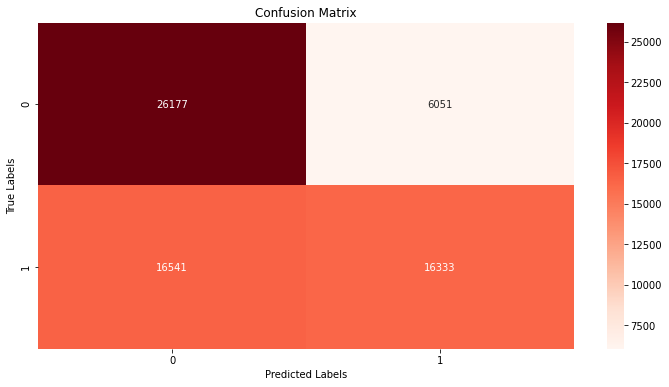

In [41]:
#  y_test и predict_final это истинные и предсказанные значения, соответственно
cm = confusion_matrix(y_test, predict_final)

# Вывод confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


`Вывод:` Мы видим, что количество истинно-отрицательных показаний (True-negative) самое высокое, при этом  истинно-положительные (True-Positive) на треьем месте.

Это говорит о хорошей предсказательной способности модели в случае негативных значений.

In [42]:
recall_score(y_test,predict_final)

0.49683640567013443

In [43]:
precision_score(y_test,predict_final)

0.7296729807005004

`Вывод:` лучшая модель Случайного Леса показала 

Полнота: 0.5029506600961245<br>
Точность: 0.7150765504714125

Полнота (recall) измеряет долю правильно классифицированных положительных случаев (true positives) относительно общего количества фактических положительных случаев. В данном случае полнота на тестовой выборке составляет 0.5029506600961245. Это означает, что модель правильно классифицировала 50% всех фактических положительных случаев.

Точность (precision) измеряет долю правильно классифицированных положительных случаев (true positives) относительно всех случаев, которые модель предсказала как положительные (true positives + false positives). В данном случае точность на тестовой выборке составляет 0.7150765504714125. Это означает, что из всех случаев, которые модель предсказала как положительные, 71% действительно являются положительными.

## Проведите анализ важности факторов ДТП

Выводим график для наглядности

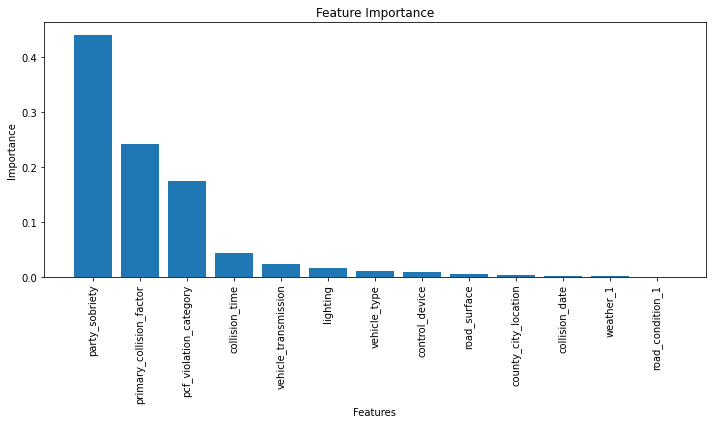

In [44]:
importance = model.named_steps['classifier'].feature_importances_


# Создаём словарь с именами параметров и их важностью
feature_importance_dict = dict(zip(preprocessor_for_tree.transformers_[0][1].get_feature_names_out(), importance))


# Сортируем важность параметров по убыванию
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
features = [feature for feature, _ in sorted_feature_importance]
importance = [importance for _, importance in sorted_feature_importance]
plt.figure(figsize=(10, 6))
plt.bar(features, importance)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


Проведём исследование признака 'party_sobriety' и зависимость целевого параметра.

In [45]:
union_df.pivot_table(index='party_sobriety', columns='at_fault', values='distance', aggfunc='count')

at_fault,0,1
party_sobriety,,
"had been drinking, impairment unknown",278,1428
"had been drinking, not under influence",461,1067
"had been drinking, under influence",507,10692
had not been drinking,101804,78770
impairment unknown,3550,16838
not applicable,828,783


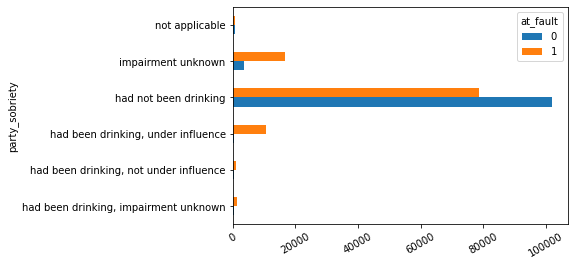

In [46]:
union_df.pivot_table(index='party_sobriety', columns='at_fault', values='distance', aggfunc='count').plot(kind='barh')

plt.xticks(rotation=30)
plt.show()

`Вывод: ` большая зависимость ДТП по неизвестной причине impairment unknown (неизвестное ухудшение). Среди невыпивших, вероятность попадания / непопадания в ДТП отличается незначительно.

Саямая явная зависимость - между ДТП и выпившим водителем под алкогольным влиянием.

`Общий вывод: `

**В результате проведённого исследования зависимости риска ДТП от разных дорожых факторов, были выполенны следущие этапы:**

- Импорт из базы данных при помощи SQL 
- Ознакосмление с данными о ДТП из трёх разных таблиц vehicles, collisions и parties.
- был провдён статистический анализ данных ДТП который выявил следущее:
подавляющее большинство ДТП происходит с января по май. предположительно, это связанно с суровыми погодными условиями зимой и весенней распутицей, а также из-за переходного периода, смены зимних шин на летние (несвоевременная смена шин).
- для потдверждения нашего предположения мы разделили задачу на подзадачи. 

- Изучить зависимость ДТП от состояния дорожного полотна
- Изучить зависимость ДТП от состояния освящённости дороги
- Изучить зависимость ДТП при нахождении на перекрёстке дорог
- Изучить есть зависимость ДТП от уровня опасности участка дорого
- Изучить зависимость ДТП от погодных условий
- Изучить зависимость ДТП от использования громкой связи за рулём
- Изучить зависимость ДТП от времени суток

Мы выборочно проанализировали боллее подробно две из них: зависимость ДТП от погодных условий и зависимость ДТП от состояния освящённости дороги.

Из проведённого анализа следует, что за исключением параметра 'ясная погода' сколько нибудь значительной разницы между присутствием или отсутствием погодного явления не надлюдается.

ДТП проиходят одинаково часто в дождь или при его отсутствии.

Папаметр clear - (ясная погода) показывает незначительную связь, на грани погрешности.

Также выявлено, что не прослеживается корреляции отсещённости и ДТП, за исключением наличия / отсутствия дневного света, но эти показатели очень близки и поэтому, ненадёжны. Можно сделать до вывод что явной взаимосвязи нет.

**Для предсказания вероятности ДТП были созданы и обучены модели RF, LGBM, Catboost в результате, лучшей моделью оказалась RF**

в результате применения лучшей модели RF на тестовой выборке были достигнуты следущие показания метрики

Полнота: 0.5029506600961245<br>
Точность: 0.7150765504714125

В итоге был определён фактор наиболее сильно врлияющий на колво ДТП - это опьянение, после подробного анализа выяснилось, что 
`саямая явная зависимость - между ДТП и выпившим водителем кторый находится под алкогольным влиянием.`


`В качестве рекомендации для дальнейшего развития проекта можно предложить следущее:`
Принимая во внимание что пьянство за рулём - основной фактор влияющий на количество ДТП, имеет смысл ввести следующие нововведения для водителей:
- применение встроенных алкотестеров
- системы распознавания водителя, чтобы убедиться что тест проводит нужный человек. Можно использовать скан радушки или лица.